Synthlabs Train split data assessmet with **HAL16Q** questions

In [16]:
import pandas as pd

In [17]:
import os, json, time

In [18]:
from getpass import getpass

In [19]:
api_key = getpass("Please input your OpenAI API Key：")

Please input your OpenAI API Key： ········


In [21]:
data = pd.read_csv("data/OOD_dataset.csv")
data.head()

,file_id,conversation_transcript,label
0,8065,"D: Hi, Jill. How are you?\n\nP: I'm okay.\n\nD...",1
1,5813,"P: Hi, doctor. I'm meeting with you today to h...",0
2,7062,"D: Hi, Lois. I received your call to the offic...",1
3,6856,"P: Hi, Doctor. I'm meeting with you today to h...",0
4,7880,"D: Hi, my name is Lauren. I'm going to be your...",1


# TinyAgent

In [23]:
from tiny_agent import TinyAgent
import os, getpass
import json
import tiktoken

# HAL16Q-Judge

In [24]:
## 14 Reasons Why

def _build_prompt_HLJ(conversation):
    return """# Human vs. AI Speaking-Style Likert-Type Numeric Rating Scale

The 16 statements below describe characteristics of human-likeness in a speaker’s dialogue within a Turing test scenario. Please rate the speaking style of Patient P, based only on their portion of the provided dialogue, using the following scale:

- Score 5: The trait is conclusively present (high agreement with the statement).
- Score 3: The trait is somewhat present, not relevant, or there is only medium agreement.
- Score 1: The trait is mostly absent (low agreement with the statement).

Rate it low if you have any reason to do so. If uncertain, err on the side of a lower rating.

Only consider Patient P's dialogue; ignore all statements or actions by Doctor D.

**Likert Statements**

1. Keeps replies brief and casual without over-explaining.
2. Uses emojis, emoticons, and playful elongations.
3. Makes niche cultural references from personal memory and assumes shared context.
4. Uses lowercase texting style.
5. Shows small typos, uneven punctuation, and informal grammar typical of quick texting.
6. Builds on the other person's message and context.
7. Uses natural, idiomatic phrasing.
8. Shows reciprocity by asking natural, context-aware follow-up questions that advance the chat.
9. Uses casual, playful humor.
10. Admits not knowing and asks to learn instead of inventing details.
11. References immediate context or recent activity.
12. Uses casual slang, abbreviations, and shorthand naturally.
13. Explains choices with simple personal reasons and constraints.
14. Stays on topic and steers the conversation rather than mirroring or deflecting.
15. Sometimes shows impatience and ends the chat quickly with a brief nicety.
16. Gives direct answers about self with concrete personal details.

## Required Input

You must supply Patient P's dialogue only (exclude all of Doctor D’s lines) to allow the system to perform this evaluation.

## Output Format and Verbosity

Return a valid JSON object containing ratings for each statement, with statement numbers (1–16). The value for each statement must be an integer from 1 to 5. Do not include any text or commentary outside the JSON object.

- Limit your output to the JSON object only, with no introductory or concluding remarks.
- Ensure the JSON object is compact and free of extra whitespace or lines.
- Prioritize providing a complete, actionable evaluation for all 16 statements within this format cap.

Output format:
```json
{
  "likert_evaluation": {
      "1": INT(1-5),
      ...
      "7":  INT(1-5)
      "8":  INT(1-5),
      ...
      "16":  INT(1-5),
  }
}
```

Error message format:
```json
{
    "error": "message..."
}
```

## Input dialogue:
<dialogue>
"""+conversation+"\n\n"

In [25]:
import re
import statistics
import json
import numpy as np

# coefficient of variation (CV)
#
def coeff_var(dialogue, speakers=['D', 'P'], target='P'):
    """
    CV = 0: no variation (all values identical).
    CV < 0.1: very low variation.
    CV ≈ 0.1–0.3: moderate variation.
    CV > 0.5: high variation or data widely spread.
    """
    s1, s2 = speakers
    
    pattern = rf'^({s1}|{s2}):\s*(.*?)(?=^(?:{s1}|{s2}):|\Z)'
    matches = re.findall(pattern, dialogue, flags=re.S | re.M)
    
    Speaker1, Speaker2 = [], []
    target_lens = []
    for speaker, line in matches:
        cleaned = line.strip().replace('\u2019', "'").replace('\u2014', '—')
        if speaker == target:
            Speaker2.append(cleaned)
            target_lens.append(len(cleaned.split()))
        else:
            Speaker1.append(cleaned)
    try:
        cv = statistics.stdev(target_lens)/statistics.mean(target_lens)
    except:
        cv = 0
    return cv, len(target_lens)


def get_judge_choices(conversation, model, reasoning_effort="low", debug=False):
    try:
        # if "oss" in model:
        #     agent = TinyAgentOSS(model)
        # else:
        #     agent = TinyAgent(model)
        agent = TinyAgent(model, api_key=api_key)
        agent.set_debug(debug)
        agent.set_reasoning_effort(reasoning_effort)
        agent.clear_messages()
        agent.add_user_message(_build_prompt_HLJ(conversation))
        result = agent.call_json()
        if debug:
            print(f"Response from get_judge_choices {result}./nType: {type(result)}")
        return extract_likert_integers(result, debug)
    except Exception as e:
        print(f"get_judge_choices error: {e}")
        return None
    
def extract_likert_integers(data, debug=False):
    key = list(data.keys())[0]
    eval_dict = data[key]
    if debug:
        print(f"extract_likert_integers dict found: {eval_dict}")
    values = list(eval_dict.values())
    if len(values) != 16:
        return None
    return values

def clean_dialogue(text):
    if pd.isna(text):
        return text
    # Replace multiple newlines with one
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r'---', '', text)
    text = re.sub(r'[ \t]+', ' ', text)
    # Remove everything before the first "P:"
    text = re.sub(r'^.*?P:', 'P:', text, flags=re.DOTALL).strip()
    # text += '\n</dialogue>\n'
    return text

def extract_dialogue(text):
    parts = text.split("\n---\n", 2)
    return parts[2].strip() if len(parts) == 3 else ""

with open("HAL16_judge_weights.json", "r") as f:
    parameters = json.load(f)

w_final = np.array(parameters["w"])
b_final = parameters["b"]

def hal16_score(arr):
    arr = np.array(arr)
    return float(arr.dot(w_final) + b_final)

## Judge Turing data

In [26]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_row_single( row, 
                        model_name="gpt-5", 
                        reasoning_effort="high", 
                        # id_column="dialogue_id", 
                        id_column="file_id",
                        root_key = "likert_evaluation",
                        debug = False
                        ):
    """
    This method is specifically built for evaluating the Turing test dataset, two dialogue at a time.
    Input: row containing two dialogue
    Output: Same row, with few added columns
    """
    idx = row[id_column]
    try:
        start_time = time.time()
        conversation = clean_dialogue(str(row["conversation_transcript"]))
        cv, dialogue_len = coeff_var(conversation, ['P', 'D'], 'P')

        result = get_judge_choices(conversation, model_name, reasoning_effort, debug)

        if debug:
            print(f"process_row_double A: {result}")
        
        tr = row.copy()
        score_mean = sum(result)/len(result)
        tr[root_key] = result
        tr["hal16_score"] = hal16_score(result)
        tr[root_key+"_mean"] = score_mean
        tr["cv"] = cv
        tr["elapsed_time"] = time.time() - start_time

        # Start with all original columns
        output = dict(row)

        # Add new columns
        output.update(tr)

        return output

    except Exception as e:
        print(f"process_row_double Error: {e}, {id_column}: {idx}")
        return None

In [27]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_parallel(data: pd.DataFrame,
                        process_method,
                        num_workers: int = 4,
                        output_path: str = "output.csv",
                        # model_name: str = "gpt-5-mini",
                        model_name: str = "gpt-5",
                        reasoning_effort: str = "high",
                        print_every: int = 1,
                        id_column: str = "game_id",
                        root_key: str = "likert_evaluation"
                    ):

    data = data.copy()
    if os.path.exists(output_path):
        print(f"File exists. Loading {output_path}")
        output_csv = pd.read_csv(output_path)
        results = json.loads(output_csv.to_json(orient="records", indent=2))
        data = data[~data[id_column].isin(output_csv[id_column])]
        print(f"Starting generation after {len(output_csv)}. Remaining data: {len(data)}")
    else:
        print("File not found, creating new file.")
        results = []

    tasks = [row for _, row in data.iterrows()]
    num_workers = min(num_workers, len(data))
    print(f"Total task: {len(tasks)} | Number of Workers: {num_workers}")

    if len(tasks) == 0:
        print(f"No tasks to do, exiting.")
        return

    program_start_time = time.time()

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        futs = [ex.submit(process_method, row, model_name, reasoning_effort, id_column, root_key) for row in tasks]

        for i, fut in enumerate(as_completed(futs), 1):
            r = fut.result()
            if r:
                results.append(r)

                pd.DataFrame(results).to_csv(output_path, index=False)

                if i%print_every == 0:
                    elapsed_time = r["elapsed_time"]
                    print(f"[Saved row {i}] Progress {i}/{len(futs)} | Current total saved {len(results)} | Time row {elapsed_time} | Time total {time.time() - program_start_time}")
            else:
                print(f"[Skipped row {i}] Progress {i}/{len(futs)} | Current total saved {len(results)}")

    print(f"Done. Saved to {output_path}  | Time {time.time() - program_start_time} | Average time: {(time.time() - program_start_time)/max(1,len(results))}")

## Single test

In [28]:
process_row_single(data.iloc[5], model_name="gpt-5")
# process_row_single(data.iloc[5], model_name="gpt-oss:120b")

{'file_id': np.int64(4584),
 'conversation_transcript': "P: Hello.\n\nD: Hello.\n\nP: Hi. Hey.\n\nD: Hi. So we just got your results back from your scans and could we have a talk about it?\n\nP: Yeah, I'm, I'm. Yeah, hoping some things. There's been some progress, at least after everything that I've been through. So. Yeah. What's. What's going on? Sorry, I'm just a little. I, I'm all good. I'm just. My kids and things are not here. My kids are not here at the moment. It's a little quiet and whatnot, so I'm a little on edge.\n\nD: It's all good. So after the results that we got back, unfortunately we did receive some bad news that after that, the CT did in fact show that it did not get better and that unfortunately, there are no therapies available to really help it. It is possible that with chemotherapy.\n\nP: Sorry, wait. Okay. So. So is. It. Is better? Are things. Are things. Are things in a better place?\n\nD: Unfortunately, it is not better. And it does seem to be terminal.\n\nP: T

# Run inference

In [29]:
output_dir = "data"
output_filename = "OOD_dataset_result"

!ls $output_dir

dpo_train_hal16.csv
OOD_dataset.csv
OOD_dataset_result_scored_gpt-5.csv
prompts_synthlabs_dialogues_test.csv
prompts_synthlabs_dialogues_train.csv
synthlabs_dialogues_test.csv
synthlabs_dialogues_train.csv
synthlabs_dialogues_train_scored_gpt-5.csv
synthlabs_dialogues_train_scored_gpt-5-mini.csv
synthlabs_test_dialogues_seven_models.json
synthlabs_train_dialogues_seven_models.json
turing_test_over_50.csv


In [30]:
model_name = "gpt-5"
reasoning_effort = "high"
# id_column = "dialogue_id"
id_column = "file_id"
root_key = "likert_evaluation"
num_workers = 4 if "oss" in model_name else 500

output_path = f"{output_dir}/{output_filename}_scored_{model_name}.csv".replace(":", "-")
print(output_path, num_workers)

data/OOD_dataset_result_scored_gpt-5.csv 500


In [32]:
process_parallel(data,
                process_row_single,
                num_workers = num_workers,
                output_path = output_path,
                model_name = model_name,
                reasoning_effort = reasoning_effort,
                print_every = 10,
                id_column = id_column,
                root_key = root_key
            )

File not found, creating new file.
Total task: 146 | Number of Workers: 146
[Saved row 10] Progress 10/146 | Current total saved 10 | Time row 29.902450561523438 | Time total 31.58093547821045
[Saved row 20] Progress 20/146 | Current total saved 20 | Time row 33.620479583740234 | Time total 33.64636778831482
[Saved row 30] Progress 30/146 | Current total saved 30 | Time row 34.8852424621582 | Time total 35.88921594619751
[Saved row 40] Progress 40/146 | Current total saved 40 | Time row 37.080179929733276 | Time total 37.10654044151306
[Saved row 50] Progress 50/146 | Current total saved 50 | Time row 36.09978699684143 | Time total 37.82709312438965
[Saved row 60] Progress 60/146 | Current total saved 60 | Time row 39.163963079452515 | Time total 39.1786527633667
[Saved row 70] Progress 70/146 | Current total saved 70 | Time row 40.374929428100586 | Time total 40.4077627658844
[Saved row 80] Progress 80/146 | Current total saved 80 | Time row 41.35522961616516 | Time total 41.369815111

# Output Analysis

In [33]:
output_path = 'data/OOD_dataset_result_scored_gpt-5.csv'

In [34]:
import pandas as pd

In [35]:
output = pd.read_csv(output_path)
output.columns

Index(['file_id', 'conversation_transcript', 'label', 'likert_evaluation',
       'hal16_score', 'likert_evaluation_mean', 'cv', 'elapsed_time'],
      dtype='object')

In [36]:
len(output)

146

In [37]:
output.head()

,file_id,conversation_transcript,label,likert_evaluation,hal16_score,likert_evaluation_mean,cv,elapsed_time
0,9390,"D: Hello. Hi, I'm Dr. Malad.\n\nP: Hi, Dr. Mal...",1,"[5, 1, 1, 1, 2, 4, 5, 2, 1, 1, 4, 2, 4, 3, 1, 5]",0.184655,2.6250,1.010062,22.248266
1,6126,"P: Hi, doctor. I'm meeting with you today to h...",0,"[2, 1, 1, 1, 1, 5, 5, 1, 1, 1, 5, 1, 1, 3, 1, 2]",-4.499591,2.0000,0.192866,25.642924
2,2279,P: Hi doctor. I'm meeting with you today to he...,0,"[2, 1, 1, 1, 1, 5, 5, 5, 1, 5, 5, 1, 1, 5, 1, 3]",-6.273468,2.6875,0.202479,27.178180
3,8545,"P: Hi, Doctor. I'm meeting with you today to h...",0,"[2, 1, 1, 1, 1, 5, 5, 5, 1, 5, 5, 1, 4, 5, 1, 2]",-5.054221,2.8125,0.154175,28.049248
4,7041,"P: Hi, Doctor. I'm meeting with you today to h...",0,"[2, 1, 1, 1, 1, 5, 5, 5, 1, 5, 5, 1, 1, 4, 1, 5]",-6.472595,2.7500,0.394156,29.519520


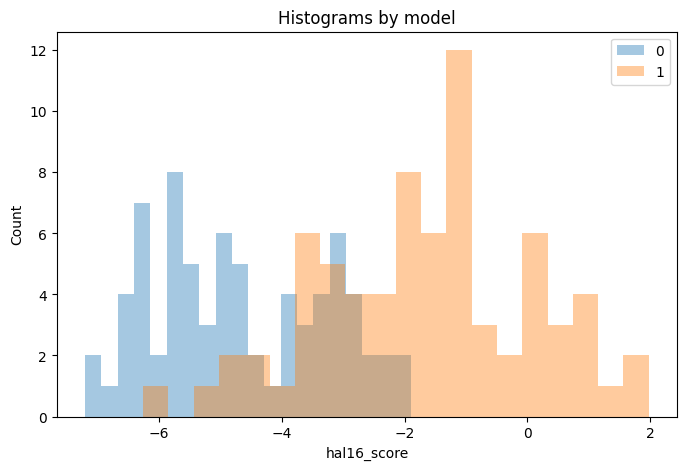

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for label in [0,1]:
    subset = output[output["label"] == label]["hal16_score"]
    plt.hist(subset, bins=20, alpha=0.4, label=label)

plt.xlabel("hal16_score")
plt.ylabel("Count")
plt.title("Histograms by model")
plt.legend()
plt.show()


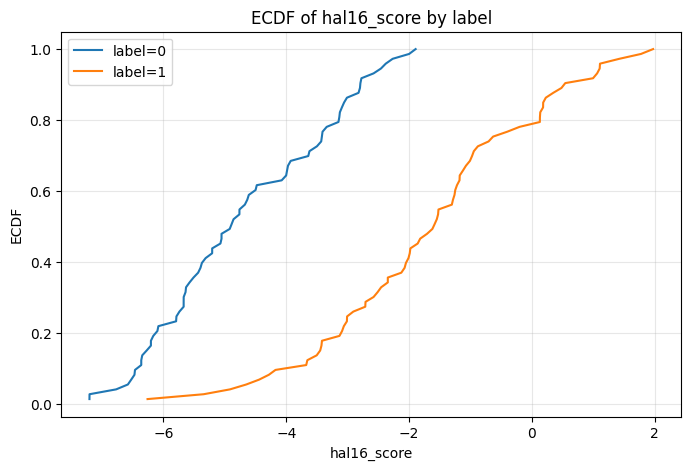

In [57]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for label in [0, 1]:
    x = np.sort(output[output["label"] == label]["hal16_score"].dropna().values)
    y = np.arange(1, len(x) + 1) / len(x)
    plt.plot(x, y, label=f"label={label}")

plt.xlabel("hal16_score")
plt.ylabel("ECDF")
plt.title("ECDF of hal16_score by label")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


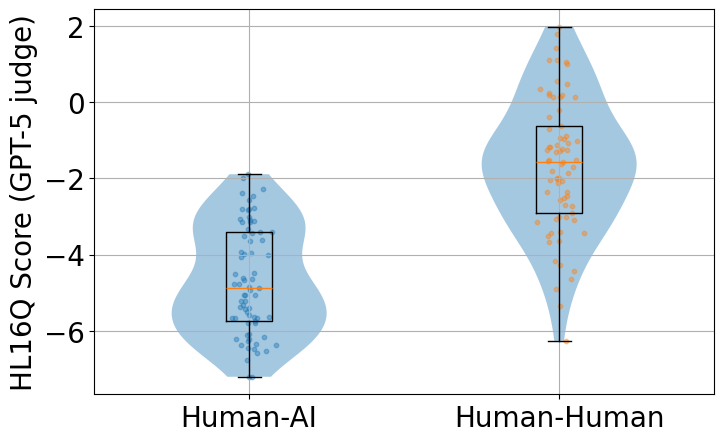

In [68]:
import numpy as np
import matplotlib.pyplot as plt

data0 = output[output["label"] == 0]["hal16_score"].dropna().values
data1 = output[output["label"] == 1]["hal16_score"].dropna().values

plt.figure(figsize=(8, 5))

# violin
parts = plt.violinplot([data0, data1], positions=[0, 1], showextrema=False)
for pc in parts["bodies"]:
    pc.set_alpha(0.4)

# box
plt.boxplot([data0, data1], positions=[0, 1], widths=0.15)

# jittered points
plt.scatter(
    np.random.normal(0, 0.03, size=len(data0)), data0, s=10, alpha=0.4
)
plt.scatter(
    np.random.normal(1, 0.03, size=len(data1)), data1, s=10, alpha=0.4
)

plt.xticks([0, 1], ["Human-AI", "Human-Human"], fontsize=20)
plt.ylabel("HL16Q Score (GPT-5 judge)", fontsize=20)
plt.yticks(fontsize=20)

# plt.title("Distribution of HL16Q Score by label")
plt.grid(True)
plt.savefig(f"Plots/ood.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [69]:
import numpy as np
from scipy.stats import mannwhitneyu, ttest_ind
from sklearn.utils import resample

ha = output[output["label"] == 0]["hal16_score"].dropna().values
hh = output[output["label"] == 1]["hal16_score"].dropna().values

# 1) Mann–Whitney (one-sided)
u, p_mwu = mannwhitneyu(hh, ha, alternative="greater")

# 2) Welch t-test (one-sided)
t, p_t = ttest_ind(hh, ha, equal_var=False, alternative="greater")

# 3) Mean difference + bootstrap CI
delta = hh.mean() - ha.mean()

boot = []
for _ in range(10000):
    boot.append(resample(hh).mean() - resample(ha).mean())
ci = np.percentile(boot, [2.5, 97.5])

# 4) Cliff’s delta
def cliffs_delta(x, y):
    return (np.sum(x[:,None] > y) - np.sum(x[:,None] < y)) / (len(x)*len(y))

delta_cliff = cliffs_delta(hh, ha)

print({
    "MWU_p": p_mwu,
    "Welch_p": p_t,
    "mean_diff": delta,
    "CI_95": ci,
    "cliffs_delta": delta_cliff
})


{'MWU_p': np.float64(1.0052629661446261e-17), 'Welch_p': np.float64(3.9133503050014883e-22), 'mean_diff': np.float64(3.023113160542689), 'CI_95': array([2.50125467, 3.54040263]), 'cliffs_delta': np.float64(0.8145993619816101)}


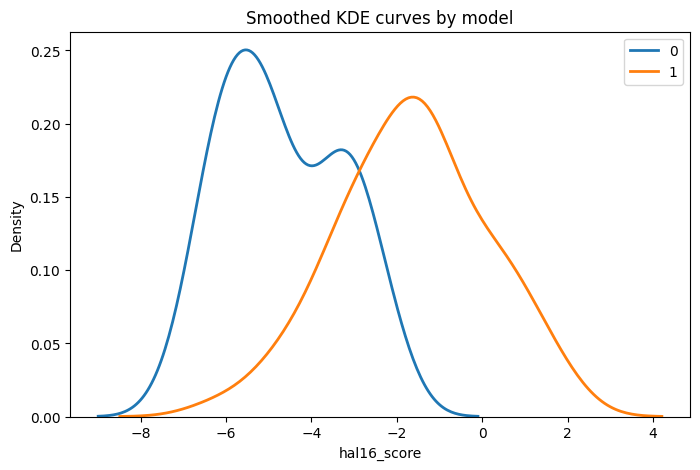

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

for label in [0,1]:
    subset = output[output["label"] == label]["hal16_score"]
    sns.kdeplot(subset, fill=False, linewidth=2, label=label)

plt.xlabel("hal16_score")
plt.ylabel("Density")
plt.title("Smoothed KDE curves by model")
plt.legend()
plt.show()


In [ ]:
std_val = output["hal16_score"].std()
mean = output["hal16_score"].mean()
print(mean, std_val)

In [44]:
means = output.groupby("label")["hal16_score"].mean().sort_values(ascending=False)
print(means)

label
1   -1.660122
0   -4.683235
Name: hal16_score, dtype: float64


<Figure size 800x500 with 0 Axes>

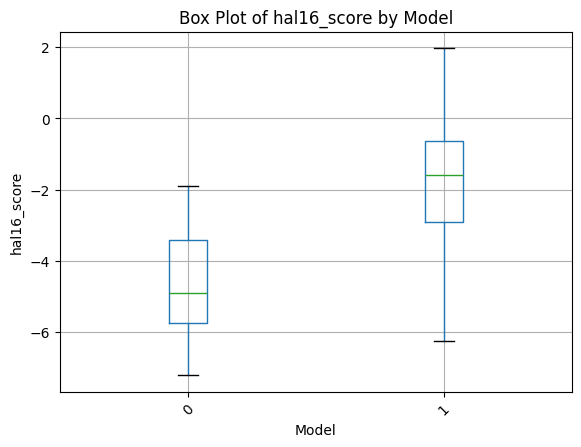

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
output.boxplot(column="hal16_score", by="label")
plt.title("Box Plot of hal16_score by Model")
plt.suptitle("")
plt.xlabel("Model")
plt.ylabel("hal16_score")
plt.xticks(rotation=45)
plt.show()


In [50]:
from scipy.stats import ttest_ind
import numpy as np

a = output.loc[output.label == 1, "hal16_score"].dropna().values
b = output.loc[output.label == 0, "hal16_score"].dropna().values

t_stat, p_two = ttest_ind(a, b, equal_var=False)

# convert two-sided p to one-sided
p_one = p_two / 2 if np.mean(a) > np.mean(b) else 1.0

print({
    "mean_A": np.mean(a),
    "mean_B": np.mean(b),
    "p_one_sided": p_one
})

{'mean_A': np.float64(-1.6601218141582013), 'mean_B': np.float64(-4.68323497470089), 'p_one_sided': np.float64(3.9133503050014883e-22)}


In [51]:
from scipy.stats import mannwhitneyu
import numpy as np

u, p = mannwhitneyu(a, b, alternative="greater")

print({
    "mean_1": np.mean(a),
    "mean_0": np.mean(b),
    "p_one_sided": p
})


{'mean_1': np.float64(-1.6601218141582013), 'mean_0': np.float64(-4.68323497470089), 'p_one_sided': np.float64(1.0052629661446261e-17)}


In [52]:
def cliffs_delta(a, b):
    return (np.sum(a[:, None] > b) - np.sum(a[:, None] < b)) / (len(a) * len(b))

print({"cliffs_delta": cliffs_delta(a, b)})

{'cliffs_delta': np.float64(0.8145993619816101)}
